*Instructions*: This runs the baseline algoritm. It is set up to run in Colab on a GPU, but should work if skipping Colab Setting and changing the paths. Name the experiment "baseline_ScenarioName" with ScenarioName being one of the scenarios described in the report. Then set the parameters to be the same as in this scenario and run all cells. 

In [1]:
experiment_name = 'baseline_base'

# Colab settings

In [16]:
#Mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

# Imports and Settings

In [14]:
#Paths
import os
from pathlib import Path
fp_repo = "/Users/roseline/Docs/AI/GITHUB/unsupervised-alignment"
# fp_repo = '/content/gdrive/My Drive/unsupervised-alignment'
fp_save = fp_repo / Path('save')
# if not os.path.exists(fp_save):
#     os.makedirs(fp_save)
os.chdir(fp_repo / Path('src'))

In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy as sp
from tqdm.notebook import tqdm
import pandas as pd
import uuid
#Custom modules
import embeddings as emb
import utils 
import models
import losses
import train
#KERAS
import keras
import tensorflow as tf

In [16]:
def gpu_avail():
  is_avail = True
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    is_avail = False
  return is_avail  
print(gpu_avail()) #Will print True if GPU is available (on Colab for instance)

False


# Parameters

In [17]:
#===PARAMETERS===\
override = False
sd = 56 #This should make the subsequend rd seed generation reproducible
tf.random.set_seed(sd)
np.random.seed(sd)
#=Synthetic data
n_systems = 2
n_concepts = 200
noise = 0.001
emb_dim = 2
n_epicentres = 1
linearsep = 1
#=Neural net
n_runs = 10
max_restart = 110 #10 last restarts to fine tune best
max_epoch = 30
batch_size = np.minimum(100, n_concepts) #64/100
#max_patience = 5
#=losses
gmm_scale = 0.01
loss_distr_scale = 1.0
loss_cycle_scale = 10000.0
#=Define models / optimizer/losses
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
#==SETUP=====
template_ceil = '    Ceiling\n    Accuracy 1: {0:.2f} 5: {1:.2f} 10: {2:.2f} Half: {3:.2f}\n'
template_loss = '    Epoch {0} Loss | total: {1:.5g} | cycle: {2:.3g} | f_dist: {3:.3g} | g_dist: {4:.3g}'
template_acc = '{0} = | 1: {1:.2f} | 5: {2:.2f} | 10: {3:.2f} | half: {4:.2f}'
template_res = '{0} = | f1: {1:.2f} | fhalf: {2:.2f} | g1: {3:.2f} | ghalf: {4:.2f} | total: {5:.2f} cycle: {6:.2f} | f_dist: {7:.2f} | g_dist: {8:.2f} '
n_batch = int(np.ceil(n_concepts / batch_size))
#==Set folders to save results and models===
fp_save_runs,fp_save_models = utils.create_save_folder(fp_save,override,n_systems,n_concepts,noise,emb_dim,
                                                 n_epicentres,linearsep,max_restart,max_epoch,batch_size,name = experiment_name)
print(fp_save_runs)
#===Get seed lists
sd_run_list = list(np.random.choice(10000, n_runs, replace=False))
#===Save params
experiment_id = uuid.uuid4()
dict_params = {'experiment_name':experiment_name,'experiment_id':experiment_id,'n_systems':n_systems,'n_concepts':n_concepts,'noise':noise,'emb_dim':emb_dim,'n_epicentres':n_epicentres,'linearsep':linearsep,
               'n_runs':n_runs,'max_restart':max_restart,'max_epoch':max_epoch,'batch_size':batch_size,'gmm_scale':gmm_scale,'loss_distr_scale':loss_distr_scale,
               'loss_cycle_scale':loss_cycle_scale,'lr':lr}
with open(str(fp_save_runs)+'/dict_params.pickle', 'wb') as handle:
  pickle.dump(dict_params, handle, protocol=pickle.HIGHEST_PROTOCOL)
display(pd.DataFrame([dict_params]))

/Users/roseline/Docs/AI/GITHUB/unsupervised-alignment/save/baseline_base


,experiment_name,experiment_id,n_systems,n_concepts,noise,emb_dim,n_epicentres,linearsep,n_runs,max_restart,max_epoch,batch_size,gmm_scale,loss_distr_scale,loss_cycle_scale,lr
0,baseline_base,0449a886-0c58-4aa6-bd35-c48ac0a6d449,2,200,0.001,2,1,1,10,110,30,100,0.01,1.0,10000.0,0.001


# Prepare synthetic data

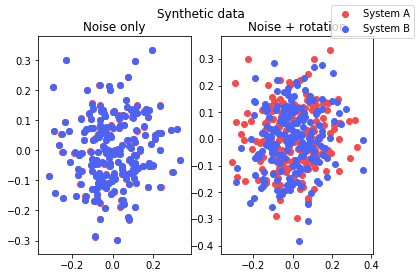

    Ceiling
    Accuracy 1: 1.00 5: 1.00 10: 1.00 Half: 1.00



In [8]:
A,B,X_A,X_B,B_shuff,B_idx_map = emb.get_data(n_systems,n_concepts,emb_dim,noise,n_epicentres,linearsep,sd,bplot=True)
# Determine ceiling performance.
acc_1, acc_5, acc_10, acc_half = utils.mapping_accuracy(X_A, X_B)
print(template_ceil.format(acc_1, acc_5, acc_10, acc_half))

In [9]:
def train_models_one_restart(i_run,i_restart,sd_restart,x,y,y_idx_map,model_f,model_g,max_epoch,n_batch,x_0,x_1):
    #LOOP THROUGH EPOCHS
    epochs_dict_list = []
    for i_epoch in range(max_epoch):
        for x_batch, y_batch in utils.get_batch(x, y, batch_size):        
            cycle_loss = train.train_batch_step(model_f,model_g,optimizer,x_batch, y_batch, loss_cycle_scale)
        dist_loss_f, dist_loss_g = train.train_full_step(model_f,model_g,optimizer,x, y,loss_distr_scale,gmm_scale)
        loss_total = dist_loss_f + dist_loss_g + cycle_loss
        # Project concept using current models
        f_x = model_f(x).numpy()
        g_y = model_g(y).numpy()
        #Get accuracies
        if y_idx_map is not None:
#             acc_f1, acc_f5, acc_f10, acc_fhalf = utils.mapping_accuracy(f_x, y.numpy()[y_idx_map]) #Does not work on local CPU
#             acc_g1, acc_g5, acc_g10, acc_ghalf = utils.mapping_accuracy(g_y[y_idx_map], x.numpy()) #Does not work on local CPU
            acc_f1, acc_f5, acc_f10, acc_fhalf = utils.mapping_accuracy(f_x, y[y_idx_map])
            acc_g1, acc_g5, acc_g10, acc_ghalf = utils.mapping_accuracy(g_y[y_idx_map], x)
        #Record all data in dict. 
        dict_entry = {'experiment_name':experiment_name,'experiment_id':experiment_id,'run':i_run,'restart':i_restart,'sd_restart':sd_restart,'epoch':i_epoch,'loss_total':loss_total.numpy(),
                      'cycle_loss':cycle_loss.numpy(),'dist_loss_f':dist_loss_f.numpy(),'dist_loss_g':dist_loss_g.numpy(),
                     'acc_f1':acc_f1, 'acc_f5':acc_f5, 'acc_f10':acc_f10, 'acc_fhalf':acc_fhalf,
                     'acc_g1':acc_g1, 'acc_g5':acc_g5, 'acc_g10':acc_g10, 'acc_ghalf':acc_ghalf}
        epochs_dict_list.append(dict_entry)
        #Print current results
        if i_epoch % max_epoch ==0 or i_epoch==max_epoch-1:
            print(template_res.format(i_epoch,acc_f1,acc_fhalf,acc_g1,acc_ghalf,loss_total,cycle_loss,dist_loss_f,dist_loss_g))
            #print('Epoch %d -'%i_epoch,template_acc.format('f(x)', acc_f1, acc_f5, acc_f10, acc_fhalf),template_acc.format('g(x)', acc_g1, acc_g5, acc_g10, acc_ghalf)) 
    #Plot final epoch
    #utils.plot_systems_results(x,y,f_x,g_y,x_0,x_1)
    return model_f,model_g,epochs_dict_list

======Run 0======
Seed :  4941


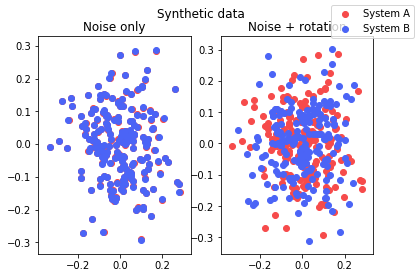

    Ceiling
    Accuracy 1: 0.99 5: 1.00 10: 1.00 Half: 1.00

    Threshold accuracy : 0.89


======Restart 0======
    New model_f
    New model_g
0 = | f1: 0.07 | fhalf: 0.71 | g1: 0.01 | ghalf: 0.78 | total: 197.50 cycle: 102.85 | f_dist: 35.55 | g_dist: 59.10 
29 = | f1: 0.03 | fhalf: 0.64 | g1: 0.03 | ghalf: 0.64 | total: 4.75 cycle: 0.04 | f_dist: 2.54 | g_dist: 2.17 
    Beat best model_f.
    Beat best model_g.
======Restart 1======
    New model_f
    New model_g
0 = | f1: 0.01 | fhalf: 0.72 | g1: 0.01 | ghalf: 0.68 | total: 171.53 cycle: 97.28 | f_dist: 37.11 | g_dist: 37.14 
29 = | f1: 0.06 | fhalf: 0.64 | g1: 0.04 | ghalf: 0.62 | total: 4.81 cycle: 0.05 | f_dist: 2.35 | g_dist: 2.41 
    Beat best model_f.
======Restart 2======
    New model_f
    New model_g
0 = | f1: 0.01 | fhalf: 0.58 | g1: 0.01 | ghalf: 0.48 | total: 134.99 cycle: 122.10 | f_dist: 6.31 | g_dist: 6.58 



KeyboardInterrupt: 

In [10]:
all_res = []
summary_res = []
for i_run in range(n_runs):
    print('===============================')
    print('======Run {0}======'.format(i_run))
    print('===============================')
    sd_run = utils.set_seed_np_tf(sd_run_list[i_run])
    print("Seed : ", sd_run)
    sd_restart_list = list(np.random.choice(10000, max_restart, replace=False))
    run_folder = fp_save_models+'/run'+str(i_run)
    utils.create_folder(run_folder+ '/final') #Same as last restart
    #==Get data 
    A,B,X_A,X_B,B_shuff,B_idx_map = emb.get_data(n_systems,n_concepts,emb_dim,noise,n_epicentres,linearsep,sd_run,bplot=True)
    ceil_acc_1, ceil_acc_5, ceil_acc_10, ceil_acc_half = utils.mapping_accuracy(X_A, X_B)
    print(template_ceil.format(ceil_acc_1, ceil_acc_5, ceil_acc_10, ceil_acc_half))
    thresh_acc = ceil_acc_1 * 0.9
    print("    Threshold accuracy : %.2f" %thresh_acc )
    x = A
    y = B_shuff
    y_idx_map = B_idx_map
#     x = tf.convert_to_tensor(x, dtype = np.float32()) #Does not work on local CPU
#     y = tf.convert_to_tensor(y, dtype = np.float32()) #Does not work on local CPU
    #Save data
    with open(str(run_folder)+'/x.pickle', 'wb') as handle:
        pickle.dump(x, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(str(run_folder)+'/y.pickle', 'wb') as handle:
        pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)
    #print(x.shape,y.shape)
    #==Loop through restarts
    #=init best
    loss_best = np.inf
    best_model_f = models.MLP(emb_dim, emb_dim)
    best_model_g = models.MLP(emb_dim, emb_dim)
    dist_loss_g_best = np.inf
    dist_loss_f_best = np.inf
    #=Loop
    last_restarts = []
    restarts_dict_list = []
    acc_f1, acc_g1 = 0,0
    last_restart = -1
    for i_restart in tqdm(range(max_restart)):
        sd_restart = utils.set_seed_np_tf(sd_restart_list[i_restart])
        print('======Restart {0}======'.format(i_restart))
        #==init models
        thresh = 0 #if 0, always a new model except if use_best_model=True. 
        force_best_model = (i_restart>=max_restart-10) #if True, use best mode, else, random depends on thresh
        model_f,new_f = models.init_model(force_best_model,thresh,i_restart,sd_restart,emb_dim,best_model_f)
        model_g,new_g = models.init_model(force_best_model,thresh,i_restart,sd_restart,emb_dim,best_model_g)
        if new_f : print('    New model_f')
        if new_g : print('    New model_g')
        #==Train
        model_f,model_g,epochs_dict_list = train_models_one_restart(i_run,i_restart,sd_restart,
                                                                    x,y,y_idx_map,model_f,model_g,max_epoch,n_batch,X_A,X_B)
        #Get final losses and accuracies
        last_epoch_dict = epochs_dict_list[-1]
        loss_total, cycle_loss, dist_loss_f, dist_loss_g = utils.get_losses_from_dict(last_epoch_dict)
        acc_f1, acc_f5, acc_f10, acc_fhalf,acc_g1, acc_g5, acc_g10, acc_ghalf = utils.get_acc_from_dict(last_epoch_dict)
        #Save best model
        best_f,best_g = False,False
        if dist_loss_f < dist_loss_f_best:
                dist_loss_f_best = dist_loss_f
                best_model_f = model_f
                best_f = True
                print('    Beat best model_f.')
        if dist_loss_g < dist_loss_g_best:
            dist_loss_g_best = dist_loss_g
            best_model_g = model_g
            best_g = True
            print('    Beat best model_g.')  
        #Add and Store data
        for i in range(len(epochs_dict_list)):
            epochs_dict_list[i]['new_f']=new_f
            epochs_dict_list[i]['new_g']=new_g
            epochs_dict_list[i]['best_f']=best_f
            epochs_dict_list[i]['best_g']=best_g
        restarts_dict_list.append(epochs_dict_list)
        #====Save restart model
        restart_folder = run_folder + '/restart' + str(i_restart)
        utils.create_folder(restart_folder)
        utils.save_models(model_f,model_g,restart_folder)
        #====Breaking loop
        if (acc_f1>thresh_acc and acc_g1>thresh_acc) and last_restart==-1: #last_restart = -1 if this does not happen
            last_restart = i_restart
            print("%d restarts necessary" %(i_restart+1))
            #break
    if last_restart==-1: 
      last_restart = max_restart
    all_dict_entries = utils.flatten_list_of_list(restarts_dict_list) 
    all_res.append(all_dict_entries)
    #STORE FINAL RESULTS
    summary_dict = {'experiment_name':experiment_name,'experiment_id':experiment_id,'sd_run':sd_run,'last_restart': last_restart,'loss_total':loss_total,'cycle_loss':cycle_loss,
                    'dist_loss_f':dist_loss_f,'dist_loss_g':dist_loss_g,
                    'acc_f1':acc_f1, 'acc_f5':acc_f5, 'acc_f10':acc_f10, 'acc_fhalf':acc_fhalf,
                    'acc_g1':acc_g1, 'acc_g5':acc_g5, 'acc_g10':acc_g10, 'acc_ghalf':acc_ghalf,
                    'ceil_acc_1':ceil_acc_1, 'ceil_acc_5':ceil_acc_5, 'ceil_acc_10':ceil_acc_10, 'ceil_acc_half':ceil_acc_half}
    summary_res.append(summary_dict)
    print(print('======Run Summary======'))
    print(display(pd.DataFrame([summary_dict])))
    #=====SAVE RUN MODEL====
    utils.save_models(model_f,model_g,run_folder+ '/final')
print('=========================')
print('=======FINAL SUMMARY=====')
print('=========================')
df_summary = pd.DataFrame(summary_res)
display(df_summary)
#Save results
with open(str(fp_save_runs)+'/all_res.pickle', 'wb') as handle:
    pickle.dump(all_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(str(fp_save_runs)+'/summary_res.pickle', 'wb') as handle:
    pickle.dump(summary_res, handle, protocol=pickle.HIGHEST_PROTOCOL)